In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [2]:
data = load_breast_cancer().data
target = load_breast_cancer().target

In [3]:
data = (data - data.mean(axis = 0)) / data.std(axis = 0)

In [4]:
clfs = []
dt = DecisionTreeClassifier(random_state = 317); clfs.append(dt)
lr = LogisticRegression(random_state = 317); clfs.append(lr)
knn = KNeighborsClassifier(); clfs.append(knn)
svm = SVC(probability = True, random_state = 317); clfs.append(svm)

# Holdout

In [5]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, stratify = target, random_state=725)

In [6]:
pred_results=[]             
for clf in clfs:
    clf.fit(X_train, y_train)
    pred_proba = clf.predict_proba(X_val)[:, 1]
    pred = clf.predict(X_val)
    name = type(clf).__name__
    pred_results.append(pd.Series(pred_proba, name = name))
    print('model : %s\n\t\t\t\tlogloss : %.4f, accuracy : %.4f'%(name, log_loss(y_val, pred), accuracy_score(y_val, pred)))

model : DecisionTreeClassifier
				logloss : 3.3327, accuracy : 0.9035
model : LogisticRegression
				logloss : 0.3030, accuracy : 0.9912
model : KNeighborsClassifier
				logloss : 0.9089, accuracy : 0.9737
model : SVC
				logloss : 0.3030, accuracy : 0.9912


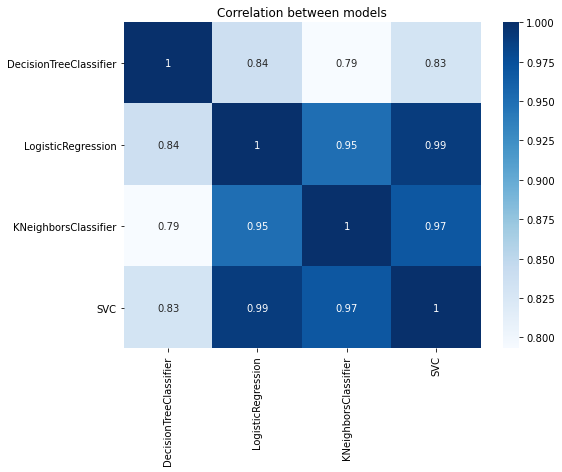

In [7]:
results=pd.concat(pred_results, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(results.corr(), annot=True, cmap='Blues')
plt.title('Correlation between models')
plt.show()

# CrossValidation

In [8]:
kfold = StratifiedKFold(n_splits = 4, random_state = 317)

In [9]:
for clf in clfs:
    score = cross_val_score(clf, data, target, cv = kfold, scoring = 'accuracy').mean()
    name = type(clf).__name__
    print('model : %s\n\t\t\t\taccuracy : %f'%(name, score))

model : DecisionTreeClassifier
				accuracy : 0.896336
model : LogisticRegression
				accuracy : 0.977162
model : KNeighborsClassifier
				accuracy : 0.964863
model : SVC
				accuracy : 0.973653


In [10]:
clf_names=[type(clf).__name__ for clf in clfs]
for clf in clfs:
    score = []
    for train_idx, val_idx in kfold.split(X_train, y_train):
        t, v = data[train_idx], data[val_idx]
        y_t, y_v = target[train_idx], target[val_idx]
        clf.fit(t, y_t)
        pred=clf.predict(v)
        acc = accuracy_score(y_v, pred)
        
        score.append(acc)

    score = np.mean(score)
    name = type(clf).__name__
    print('model : %s\n\t\t\t\taccuracy : %f'%(name, score))

model : DecisionTreeClassifier
				accuracy : 0.920917
model : LogisticRegression
				accuracy : 0.971452
model : KNeighborsClassifier
				accuracy : 0.958295
model : SVC
				accuracy : 0.967066


In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
seed = [317, 725, 923]

In [13]:
lr_params = {'C': [0.05, 0.1, 0.5, 1, 5, 10],
            'max_iter' : [50, 100, 150],
            'random_state' : seed}
grid=GridSearchCV(lr, lr_params, scoring='accuracy', cv=kfold, n_jobs=-1)
grid.fit(data, target)
lr=grid.best_estimator_
print(grid.best_estimator_)
print(grid.best_score_)

LogisticRegression(C=0.5, max_iter=50, random_state=317)
0.9789101743327095


In [14]:
dt_params={'criterion' : ['gini', 'entropy'],
          'max_depth' : [3,4,5,6],
          'max_features' : [0.8, 0.9, 1],
          'min_samples_split' : [2,3,4],
          'class_weight' : [None, 'balanced'],
          'random_state' : seed}
grid=GridSearchCV(dt, dt_params, scoring='accuracy', cv=kfold, n_jobs=-1)
grid.fit(data, target)
dt=grid.best_estimator_
print(grid.best_estimator_)
print(grid.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=0.8,
                       random_state=725)
0.9490052201319806


In [15]:
svc_params={'C' : [0.01, 0.1, 1, 10],
            'gamma' : [0.001, 0.01, 0.1, 1, 10],
            'random_state' : seed}
grid=GridSearchCV(svm, svc_params, scoring='accuracy', cv=kfold, n_jobs=-1)
grid.fit(data, target)
svm=grid.best_estimator_
print(grid.best_estimator_)
print(grid.best_score_)

SVC(C=10, gamma=0.01, probability=True, random_state=317)
0.9824436127253029


In [16]:
knn_params={'n_neighbors' : [3, 5, 7, 10, 30, 50, 70, 100],
           'weights' : ['uniform', 'distance'],
           'p' : [1,2],
           'leaf_size' : [15, 30]}
grid=GridSearchCV(knn, knn_params, scoring='accuracy', cv=kfold, n_jobs=-1)
grid.fit(data, target)
knn=grid.best_estimator_
print(grid.best_estimator_)
print(grid.best_score_)

KNeighborsClassifier(leaf_size=15, n_neighbors=3, p=1)
0.9719048557076726


In [17]:
clfs = []; clfs.append(dt); clfs.append(lr); clfs.append(knn); clfs.append(svm)

In [18]:
for clf in clfs:
    score = cross_val_score(clf, data, target, cv = kfold, scoring = 'accuracy').mean()
    name = type(clf).__name__
    print('model : %s\n\t\t\t\taccuracy : %f'%(name, score))

model : DecisionTreeClassifier
				accuracy : 0.949005
model : LogisticRegression
				accuracy : 0.978910
model : KNeighborsClassifier
				accuracy : 0.971905
model : SVC
				accuracy : 0.982444


# HardVoting
#### 평가지표가 acc, recall, precision...등일 경우 사용함

In [19]:
from sklearn.ensemble import VotingClassifier

In [20]:
voting = VotingClassifier(
    estimators = [(type(clf).__name__, clf) for clf in clfs], voting = 'hard')

In [21]:
score = cross_val_score(voting, data, target, cv = kfold, scoring = 'accuracy').mean()
print(score)

0.9859524278538363


# SoftVoting(Averaging)
#### 평가지표가 roc_auc, logloss, mse...등일 경우 사용함

In [22]:
for clf in clfs:
    score_auc = cross_val_score(clf, data, target, cv = kfold, scoring = 'roc_auc').mean()
    score_logloss = cross_val_score(clf, data, target, cv = kfold, scoring = 'neg_log_loss').mean()
    name = type(clf).__name__
    print('model : %s\n\t\t\t\trocauc : %f\tlogloss : %f'%(name, score_auc, -score_logloss))

model : DecisionTreeClassifier
				rocauc : 0.951331	logloss : 1.535627
model : LogisticRegression
				rocauc : 0.995778	logloss : 0.081312
model : KNeighborsClassifier
				rocauc : 0.985543	logloss : 0.350789
model : SVC
				rocauc : 0.996834	logloss : 0.069183


In [23]:
averaging = VotingClassifier(
    estimators = [(type(clf).__name__, clf) for clf in clfs], voting = 'soft')

In [24]:
score = cross_val_score(averaging, data, target, cv = kfold, scoring = 'roc_auc').mean()
print("roc_auc :", score)
score = cross_val_score(averaging, data, target, cv = kfold, scoring = 'neg_log_loss').mean()
print("logloss :", -score)

roc_auc : 0.996357736791275
logloss : 0.07818130496798802


In [25]:
pred_results=[]             
for clf in clfs:
    clf.fit(X_train, y_train)
    pred_proba = clf.predict_proba(X_val)[:, 1]
    name = type(clf).__name__
    pred_results.append(pd.Series(pred_proba, name = name))
results=pd.concat(pred_results, axis=1)

In [26]:
results

,DecisionTreeClassifier,LogisticRegression,KNeighborsClassifier,SVC
0,0.0,1.340373e-04,0.0,0.000147
1,1.0,9.984057e-01,1.0,0.999996
2,1.0,9.991722e-01,1.0,1.000000
3,1.0,9.953819e-01,1.0,0.999993
4,0.0,1.318273e-07,0.0,0.000004
...,...,...,...,...
109,1.0,9.868335e-01,1.0,0.996774
110,0.0,3.093669e-02,0.0,0.045400
111,0.0,5.486711e-04,0.0,0.000275
112,0.0,1.269281e-03,0.0,0.000456


In [27]:
results.mean(axis = 1)

0      7.026108e-05
1      9.996005e-01
2      9.997930e-01
3      9.988437e-01
4      9.948362e-07
           ...     
109    9.959018e-01
110    1.908422e-02
111    2.059055e-04
112    4.313762e-04
113    2.551965e-04
Length: 114, dtype: float64

In [28]:
from scipy.stats.mstats import gmean

gmean(results, axis = 1)

array([0.        , 0.99960022, 0.99979298, 0.99884172, 0.        ,
       0.        , 0.        , 0.96996075, 0.99994159, 0.        ,
       0.        , 0.99994978, 0.98875028, 0.98094578, 0.        ,
       0.99998064, 0.97391153, 0.99983041, 0.        , 0.99936829,
       0.99983503, 0.        , 0.99809822, 0.        , 0.99922143,
       0.99842668, 0.99988026, 0.        , 0.99571365, 0.99999917,
       0.        , 0.99995461, 0.99131601, 0.99394245, 0.9895499 ,
       0.9998462 , 0.        , 0.98060454, 0.        , 0.        ,
       0.        , 0.99660159, 0.        , 0.8514601 , 0.99949813,
       0.        , 0.        , 0.95396278, 0.98535085, 0.99938582,
       0.        , 0.96441035, 0.96760091, 0.99986741, 0.        ,
       0.99958712, 0.        , 0.99999716, 0.        , 0.99907583,
       0.99774764, 0.99829954, 0.        , 0.99996048, 0.        ,
       0.99984622, 0.59029827, 0.74439251, 0.99981763, 0.        ,
       0.        , 0.99997124, 0.99928394, 0.99983971, 0.99894

# RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf = RandomForestClassifier(random_state = 317)
rf.fit(X_train, y_train)
pred = rf.predict_proba(X_val)
score = log_loss(y_val, pred)
cv_score = cross_val_score(rf, X_train, y_train, cv = kfold).mean()
print(score)
print(cv_score)

0.11057665819409027
0.955985095482068


In [33]:
rf_params={'max_depth' : [3,4,5,6],
           'min_samples_split' : [3, 5, 7],
           'min_samples_leaf' : [1, 3, 5],
           'n_estimators' : [300],
           'criterion' : ['gini', 'entropy']}
grid=GridSearchCV(rf, rf_params, scoring='roc_auc', cv=kfold, n_jobs=-1, verbose = 1)
grid.fit(data, target)
rf=grid.best_estimator_
print(grid.best_estimator_)
print(grid.best_score_)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   31.3s finished


RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_split=3,
                       n_estimators=300, random_state=317)
0.9929810614090876


# BaggingClassifier

In [34]:
from sklearn.ensemble import BaggingClassifier

In [35]:
bagging = BaggingClassifier(base_estimator = lr,
                           n_estimators = 100, random_state = 317)

In [36]:
cross_val_score(bagging, data, target, scoring = 'roc_auc', cv = kfold).mean()

0.9957759168963324